# Section 1: Images

In [43]:
from glob import glob
from multiprocessing import Pool

import matplotlib.pyplot as plt
import matplotlib as mpl
mpl.rcParams['figure.dpi'] = 300
imshow = plt.imshow
imshow_gray = lambda image: plt.imshow(image, cmap=plt.get_cmap('gray'), vmin=0, vmax=1)
import cv2
import numpy as np
import pandas as pd
from PIL import Image

In [14]:
images_path = {}
fonts = ["ruqa", "nask"] # "kufi"
for name in fonts:
    images_path[name] = glob(f"real_images/{name}/*")
    
images = {}
for path in fonts:
    list_images = [cv2.imread(path) for path in images_path[path]]
    images[path] = np.array(list_images)

In [15]:
def filter_white_rows(image: np.ndarray) -> np.ndarray:
    black_lines = []
    for row in image:
        for pixel in row:
            if (pixel != [255, 255, 255]).any():
                black_lines.append(True)
                break
        else:
            black_lines.append(False)
    return image[black_lines]

def filter_white_cols(image: np.ndarray) -> np.ndarray:
    black_cols = []
    image = np.swapaxes(image, 0, 1)
    for col in image:
        for pixel in col:
            if (pixel != [255, 255, 255]).any():
                black_cols.append(True)
                break
        else:
            black_cols.append(False)
    return np.swapaxes(image[black_cols], 0, 1)

def filter_white_rows_and_cols(image: np.ndarray) -> np.ndarray:
    return filter_white_cols(filter_white_rows(image))

def cut_image(image: np.ndarray, font_type: str, final_width, final_height) -> list:
    """Takes in image and cuts it to rows according to font_type and filters white rows and cols for each image and resizes it to (WIDTH, 100)"""
#     CUTS = {"kufi" : 217 , "nask" : 165 , "ruqa" : 225}
#     font_type_to_line = {"kufi": 7, "nask": 9, "ruqa": 7}
    HEIGHT, WIDTH, *_ = image.shape
    cut = 600 #CUTS[font_type]
    lines = 3 #font_type_to_line[font_type]
    
    rows = []
    for i in range(lines):
        row = image[cut * i:cut * (i+1) , 0:]
        row = filter_white_rows_and_cols(row)
        row = cv2.resize(row, dsize=(WIDTH, final_height), interpolation=cv2.INTER_NEAREST)
        rows.append(row)
        
    final_images = []
    for row in rows:
        for i in range(WIDTH // final_width):
            final_images.append(row[:, i * final_width:(i+1) * final_width])
    
    return final_images

In [16]:
# Process all photos
for font, font_images in images.items():
    for i, image in enumerate(font_images[:-1]):
        for j, final_image in enumerate(cut_image(image, font, final_width=500, final_height=200)):
            cv2.imwrite(f"data/{font}/{i+1}_{j+1}.png", final_image)

# Section 2: Model

In [17]:
import os
from glob import glob

import matplotlib.pyplot as plt
import matplotlib as mpl
mpl.rcParams['figure.dpi'] = 300
imshow = plt.imshow
imshow_gray = lambda image: plt.imshow(image, cmap=plt.get_cmap('gray'), vmin=0, vmax=1)
import cv2
import numpy as np
import pandas as pd
from PIL import Image
import torch
import torchvision
import torchvision.transforms as transforms
import torch.nn as nn
import torch.nn.functional as F

In [18]:
# Helper functions
def show(imgs):
    if not isinstance(imgs, list):
        imgs = [imgs]
    fix, axs = plt.subplots(ncols=len(imgs), squeeze=False)
    for i, img in enumerate(imgs):
        img = img.detach()
        img = torchvision.transforms.functional.to_pil_image(img)
        axs[0, i].imshow(np.asarray(img))
        axs[0, i].set(xticklabels=[], yticklabels=[], xticks=[], yticks=[])


In [29]:
num_examples = len(glob("data/**/*"))
width = 200
train, validation, test = int(num_examples * 0.85), int(num_examples * 0.1), int(num_examples * 0.05)
test += num_examples - (train + validation + test) # Deals with rounding errors
batch_size = 24

transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Grayscale(num_output_channels=1),
     transforms.Resize((width, width)),
    ])

train_transform = transforms.Compose([
                                    transform,
#                                     transforms.GaussianBlur(11),
#                                     transforms.RandomPerspective(distortion_scale=0.1, p=0.5),
#                                     transforms.RandomAffine(degrees=(-5, 5), translate=(0, 0.05), scale=(0.95, 1.05))
                                ])

dataset = torchvision.datasets.ImageFolder("data", transform=transform)
_, valid_set, test_set = torch.utils.data.random_split(dataset, [train, validation, test])

dataset_train = torchvision.datasets.ImageFolder("data", transform=train_transform)
train_set, *_ = torch.utils.data.random_split(dataset_train, [train, validation, test])


train_loader = torch.utils.data.DataLoader(train_set, batch_size=batch_size,
                                          shuffle=True, num_workers=2)
validation_loader = torch.utils.data.DataLoader(valid_set, batch_size=batch_size,
                                          shuffle=True, num_workers=2)
test_loader = torch.utils.data.DataLoader(test_set, batch_size=batch_size,
                                          shuffle=True, num_workers=2)

classes = ("kufi", "nask", "ruqa")

In [30]:
def imshow_gray(batch):
    plt.imshow(np.squeeze(batch[0][0]), cmap=plt.get_cmap('gray'), vmin=0, vmax=1)

In [31]:
class Net(nn.Module):
    def __init__(self):
        super().__init__()
        # 1 * 100 * 100
        # 10 * 50 * 50
        # 30 * 10 * 10
        self.conv1 = nn.Conv2d(1, 10, kernel_size=3, padding=1)  
        self.conv2 = nn.Conv2d(10, 30, kernel_size=3, padding=1)
        self.conv3 = nn.Conv2d(30, 50, kernel_size=3, padding=1)
        self.conv4 = nn.Conv2d(50, 70, kernel_size=3, padding=1)
        self.pool = nn.MaxPool2d(kernel_size=3, stride=2)
        
        self.fc1 = nn.Linear(70 * 11 * 11, 437) 
        self.fc2 = nn.Linear(437, 109)
        self.fc3 = nn.Linear(109, 50)
        self.fc4 = nn.Linear(50, 3)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = self.pool(F.relu(self.conv3(x)))
        x = self.pool(F.relu(self.conv4(x)))
        
        x = torch.flatten(x, 1) # flatten all dimensions except batch
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = F.relu(self.fc3(x))
        x = self.fc4(x)
        return x

def calc(inp, kernel_size, padding, stride):
    """ Calculates outputs size of conv layer"""
    return (inp + 2 * padding - (kernel_size - 1) - 1) // stride + 1

model = Net().cuda()

In [32]:
import torch.optim as optim

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.0001)

In [33]:
epochs = 15

for epoch in range(epochs):  # loop over the dataset multiple times
    for i, data in enumerate(train_loader, 0):
        inputs, labels = data
        inputs = inputs.cuda()
        
        optimizer.zero_grad()

        outputs = model(inputs)
        loss = criterion(outputs, labels.cuda())
        loss.backward()
        optimizer.step()
        
    count = 1
    running_loss = 0.0
    for i, data in enumerate(validation_loader, 0):
        inputs, labels = data
        inputs = inputs.cuda()
        
        optimizer.zero_grad()

        outputs = model(inputs)
        loss = criterion(outputs, labels.cuda())
        loss.backward()

        running_loss += loss.item()
        count += 1
    print(f"Epoch: {epoch+1}. Loss: {running_loss / count}")
        

Epoch: 1. Loss: 0.6257498535242948
Epoch: 2. Loss: 0.5264502248980782
Epoch: 3. Loss: 0.05979474870996042
Epoch: 4. Loss: 0.021296846722675997
Epoch: 5. Loss: 0.01807821299139918
Epoch: 6. Loss: 0.008093840585471216
Epoch: 7. Loss: 0.016989794371924785
Epoch: 8. Loss: 0.0033776680995122824
Epoch: 9. Loss: 0.004223909184061499
Epoch: 10. Loss: 0.12211512731896206
Epoch: 11. Loss: 0.006070121900517155
Epoch: 12. Loss: 0.0024515523526298984
Epoch: 13. Loss: 0.0026503096709017304
Epoch: 14. Loss: 0.006755219230068509
Epoch: 15. Loss: 0.03566658174333332


In [34]:
def check_accuracy(loader, model):
    num_correct = 0
    num_samples = 0
    model.eval()
    
    with torch.no_grad():
        for x, y in loader:
            x = x.cuda()
            y = y.cuda()
            
            scores = model(x)
            _, predictions = scores.max(1)
            num_correct += (predictions == y).sum()
            num_samples += predictions.size(0)
        
        print(f'Got {num_correct} / {num_samples} with accuracy {float(num_correct)/float(num_samples)*100:.2f}') 
    
    model.train()

def predict(img, model, transform=None):
    if transform:
        img = transform(img)
        img = torch.unsqueeze(img, 0)
    _, predictions = torch.max(model(img.cuda()), 1)
    
    class_preds = []
    for pred in predictions:
        class_preds.append(classes[pred])
    return class_preds

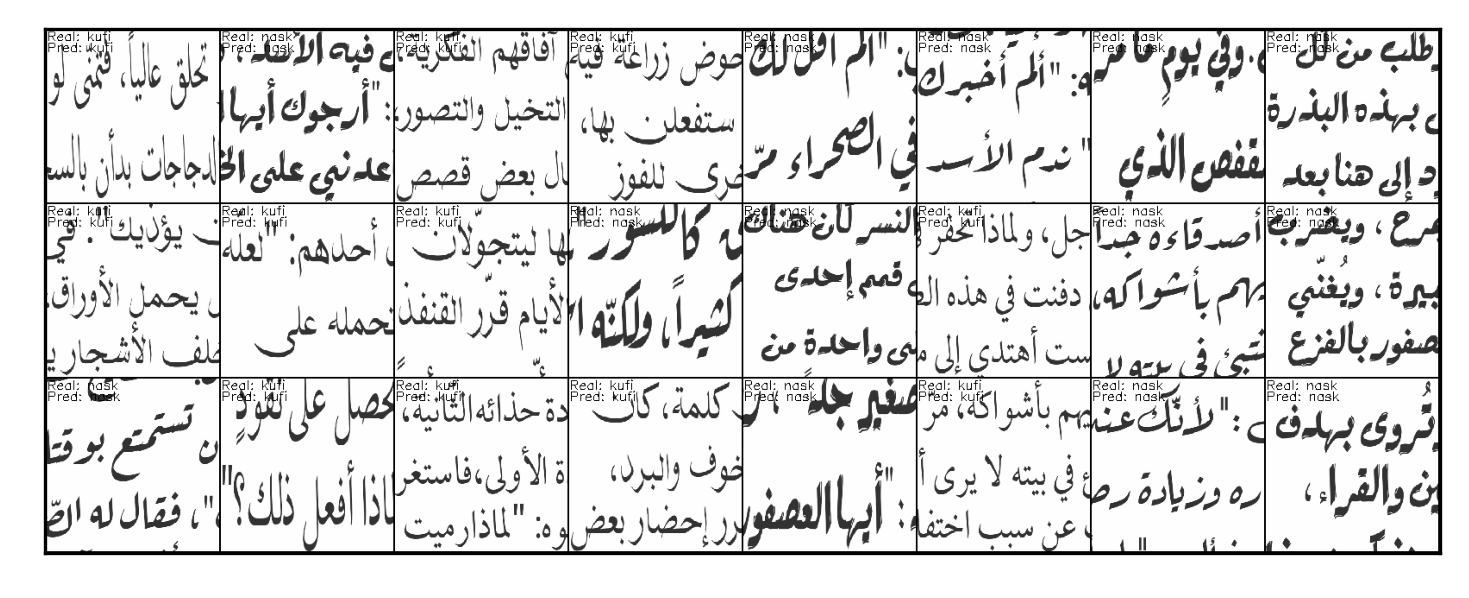

In [35]:
def add_preds_to_images(images, labels, preds):
    new_images = []
    for img, label, pred in zip(images, labels, preds):
        img = np.ascontiguousarray(img)
        img = np.squeeze(img)
        img = cv2.putText(img, f"Real: {label}", org=(0, 12), fontFace=cv2.FONT_HERSHEY_SIMPLEX, fontScale=0.5, color=(0, 50, 0), thickness=1, lineType=2)
        img = cv2.putText(img, f"Pred: {pred}", org=(0, 25), fontFace=cv2.FONT_HERSHEY_SIMPLEX, fontScale=0.5, color=(0, 0, 50), thickness=1, lineType=3)
        new_images.append(torch.unsqueeze(torch.from_numpy(img), 0))
    return torch.stack(new_images)

sample, target = next(iter(test_loader))
preds = predict(sample.cuda(), model)
show(torchvision.utils.make_grid(add_preds_to_images(sample, [classes[label] for label in target], preds)))

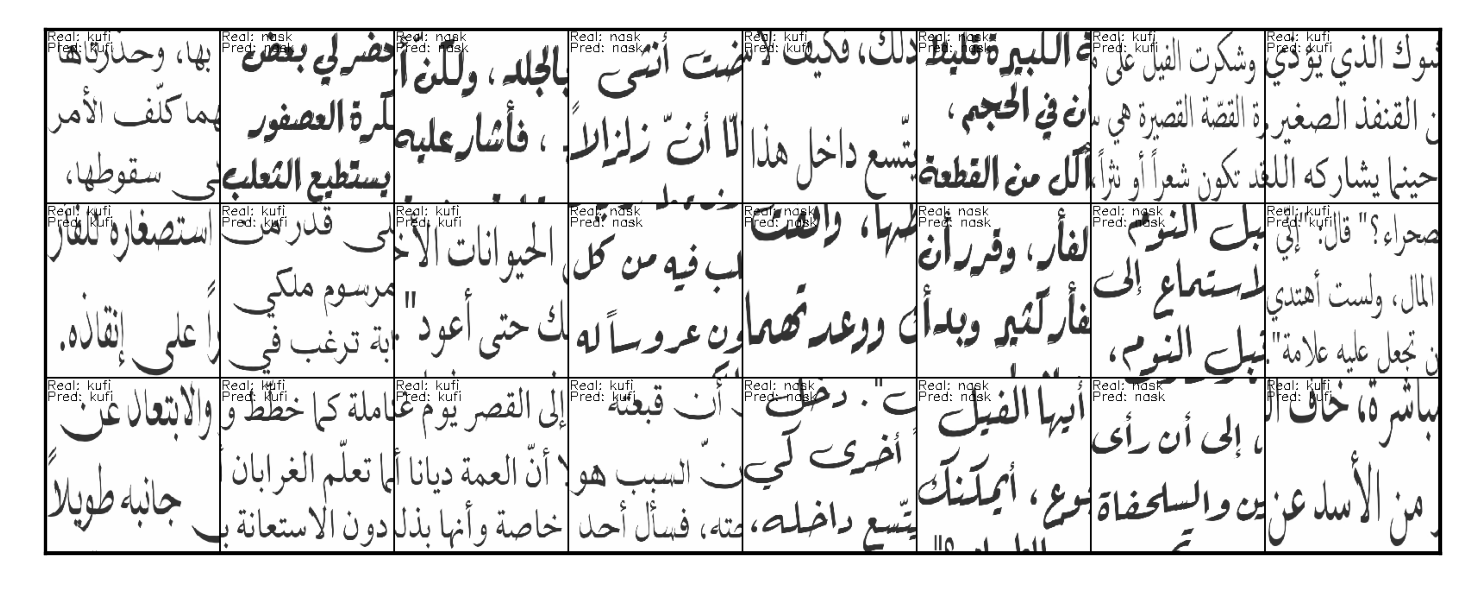

In [36]:
sample, target = next(iter(train_loader))
preds = predict(sample.cuda(), model)
show(torchvision.utils.make_grid(add_preds_to_images(sample, [classes[label] for label in target], preds)))

In [37]:
check_accuracy(train_loader, model)
check_accuracy(validation_loader, model)
check_accuracy(test_loader, model)

Got 1840 / 1856 with accuracy 99.14
Got 212 / 218 with accuracy 97.25
Got 109 / 110 with accuracy 99.09


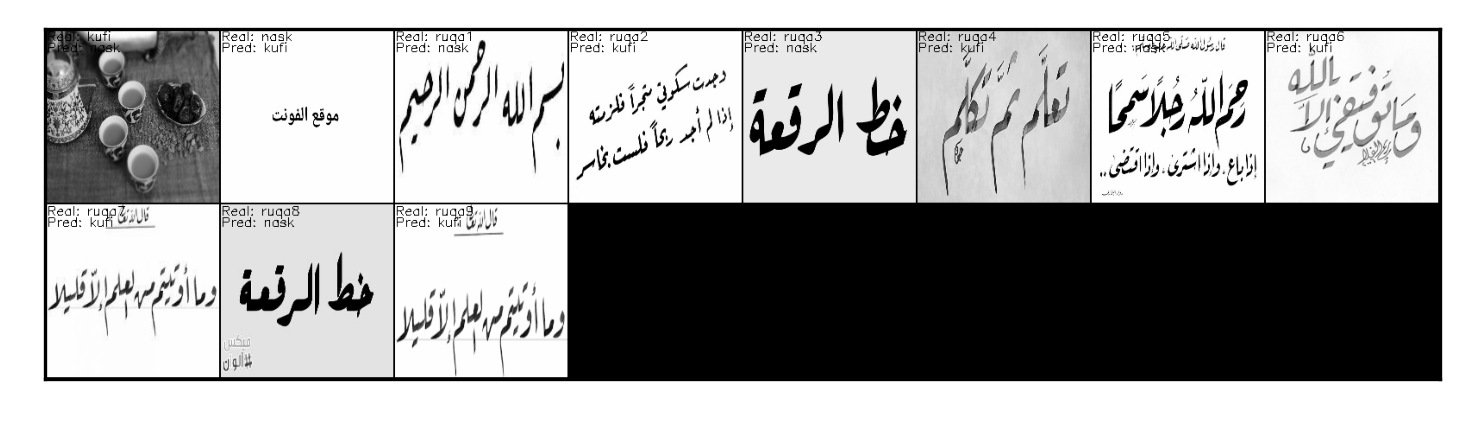

In [38]:
labels = []
images = []
for path in glob("extra_data/extra_test_samples/*"):
    labels.append(path[path.rfind("\\")+1 : path.rfind(".")])
    images.append(transform(cv2.imread(path)))
images = torch.stack(images)
preds = predict(images.cuda(), model)
show(torchvision.utils.make_grid(add_preds_to_images(images, labels, preds)))

### Save with pickle

In [9]:
import pickle
with open("model.model", "wb") as file:
    pickle.dump(model, file)

In [42]:
text = """
قصص أطفال قبل النوم يستمتع الأطفال بالاستماع إلى القصص الجميلة قبل النوم، وتمتاز هذه القصص بكونها نوعا من الأدب الفني، يُستوحى من الواقع أو الخيال، وتعد هذه القصص وسيلةً تعليميةً وتربوية ممتعةً للأطفال، تغرس فيهم قِيَماً أخلاقيّةً وتعليميّة، وتوسع آفاقهم الفكرية، وتعزز قدرتهم على التخيل والتصور، وسنذكر في هذا المقال بعض قصص الأطفال الجميلة والممتعة. الغرابان الخاسران في غابة جميلة غنّاء سمعت الحيوانات صوت شجار غرابين واقفين على غصن شجرة عالِ، فقَدِم الثعلب المكّار وحاول أن يفهم سبب شجارهما، وما إن اقترب أكثر حتى سأل الغرابين: ما بالكما أيها الغرابين؟ فقال أحدهما: اتفقنا على أن نتشارك قطعة الجبن هذه بعد أن نقسمها بالتساوي، لكنّ هذا الغراب الأحمق يحاول أن يأخذ أكثر من نصيبه، فابتسم الثعلب وقال: إذن ما رأيكما أن أساعدكما في حل هذه المشكلة، وأقسم قطعة الجبن بينكما بالتساوي؟ نظر الغرابان إلى بعضهما ووافقا على اقتراح الثعلب، وأعطياه قطعة الجبن، فقسم الثعلب قطعة الجبن وقال: يا إلهي لقد أخطأت في قسمتها، فهذه القطعة تبدو أكبر من تلك، سآكل من القطعة الكبيرة قليلاً حتى تتساوى القطعتان في الحجم، فالعدل هو الأساس، وأكل من القطعة الكبيرة قضمة حتى أصبحت أصغر من الأولى، فاعتذر للغرابين على خطئه وقرّر أن يأكل من القطعة الأولى حتى تصبحان متساويتين فهذا هو الحل الوحيد، وظلّ الثعلب على هذه الحال يقسم القطعة بشكل غير متساوِ متعمداً، ثمّ يأكل من قطعة فتصبح أصغر من الأخرى حتى أكل قطعة الجبن كاملة كما خطّط وفرّ من الغرابين هارباً، بينما تعلّم الغرابان أن يحلّا مشاكلهما بنفسيهما دون الاستعانة بالثعلب الشرير. القنفذ والحيوانات الصغيرة كان هناك قنفذٌ صغيرٌ يعيش في غابةٍ جميلة اسمه قنفود، وكان يحب اللعب مع الحيوانات، إلّا أنّ الحيوانات كانت تخشى اللعب معه، فظهره مليءٌ بالشوك الذي يؤذي الحيوانات عند اقترابها من القنفذ الصغير، فتارّة يثقب كرة الأرنب حينما يشاركه اللعب فيها، وتارّة أخرى يؤلم يد السلحفاة حينما يمسكها ليتجوّلان سويّا، وفي يوم من الأيام قرّر القنفذ الصغير أن يدخل بيته وألّا يغادره أبداً لأنّه يحب أصدقاءه جداً ولا يرغب في أن يؤذيهم بأشواكه، مرّ يومان والقنفذ مختبئ في بيته لا يرى أحداً، سألت الحيوانات عن سبب اختفائه، وحينما عرفوا السبب قرّروا أن يفاجئوه بهدية ستساعده على حل مشكلته، وفي نفس الوقت لن تبعده عن أصدقائه الذين يحبهم ويحبونه، اجتمع الأصدقاء وأحضروا لقنفود هدية وذهبوا إلى بيته، وعندما طرقوا الباب فتح لهم ودموع الشوق تملأ عينيه، ابتسم الأصدقاء وطلبوا منه أن يفتح الهدية، فتح قنفود الهدية لكنّه لم يجد سوى قطعاً صغيرة من الفَلِّين، فلم يفهم ما هذه! اقترب الأصدقاء جميعاً وأخذوا يضعون هذه القطع على الأشواك الموجودة على ظهر قنفود حتى غطوها جميعاً وحضنوه بقوّة وحب، انطلق قنفود والأصدقاء للعب في الغابة دون خوف فالصداقة أقوى من أن تغلبها أيّ مشكلة. الثعلب الماكر في أحد الأيام كانت هناك غابةٌ كبيرة، وكان فيها أسدٌ يخيف الحيوانات ويؤذيها، فاجتمعت حيوانات الغابة وقررت التعاون معاً والتصدي لبطش الأسد وأذاه، وخرجوا بخطةٍ ذكية تقضي بحبسه في قفص، وبالفعل نجحت خطتهم الذكية، فحبسوا الأسد، وأصبحوا يعيشون في سعادةٍ وأمان. وفي يومٍ ما مرّ أرنبٌ صغير بجانب القفص الذي حُبس فيه الأسد، فقال الأسد للأرنب: "أرجوك أيها الأرنب الصغير أن تساعدني على الخروج من هذا القفص" ردّ عليه الأرنب: "كلا، لن أخرجك أبداً، فأنت تعذب الحيوانات وتأكلهم"، قال الأسد: " أعدك أنّني لن أعود إلى هذه الأفعال، وسأصبح صديقاً لجميع الحيوانات، ولن أؤذي أيّاً منهم". صدّق الأرنب الصغير الطيّب كلمات الأسد ففتح له باب القفص وساعده على الخروج، وبمجرد خروج الأسد وثب على الأرنب وأمسك به، ثمّ قال: "أنت فريستي الأولى لهذا اليوم!" بدأ الأرنب بالصراخ والاستغاثة مذعوراً، وكان هناك ثعلبٌ ذكيٌّ قريبٌ منهم، فسمع استغاثات الأرنب وهرع مسرعاً كي يساعده، وحين وصل ذهب إلى الأسد وتوجه إليه بالكلام قائلاً: "لقد سمعتُ أنّك كنت محبوساً في هذا القفص، فهل ذلك حقيقيٌّ حقاً؟" فقال الأسد: "أجل، لقد حبَسَتني الحيوانات فيه". ردّ الثعلب: "ولكنّني لا أصدق ذلك، فكيف لأسد كبيرٍ وعظيمٍ مثلك أن يتّسع داخل هذا القفص الصغير؟ يبدو أنّك تكذب عليّ". ردّ الأسد: " لست أكذب، وسأثبت لك أنّني كنت داخل هذا القفص". دخل الأسد القفص مرةً أخرى كي يُري الثعلب أنّه يتّسع داخله، فاقترب الثعلب من باب القفص سريعاً وأغلقه بإحكام، وحبس الأسد فيه مرةً أخرى، ثمّ قال للأرنب: "إياك ان تصدق هذا الأسد مرةً أخرى". الأسد والفأر في يومٍ من الأيام كان ملك الغابة الأسد نائماً، فصعد فأرٌ صغير على ظهره وبدأ باللعب، شعر الأسد بالانزعاج من الحركة على ظهره واستيقظ غاضباً، فأمسك الفأر، وقرر أن يأكله مباشرةً، خاف الفأر كثيراً وبدأ بالاعتذار من الأسد عن إزعاجه، ورجاه أن يحرره ولا يأكله، ثمّ وعده بأنّه إن فعل ذلك فسينقذه يوماً، ضحك الأسد بسخرية، فكيف لفأرٍ صغيرٍ أن يساعد أسداً قوياً، ولكنّه قرر تركه. وبعد مرور بضعة أيام جاءت مجموعةٌ من الصيادين، وأمسكوا الأسد، وأحكموا وثاقه بالحبال حتى يحضروا قفصاً لوضعه فيه، فرأى الفأرُ الأسدَ على هذه الحال وتذكر وعده له، فاقترب منه وبدأ بقضم الحبال حتى قطّعها واستطاع الأسد والهرب والابتعاد عن الصيادين قبل أن ينتبهوا إليه، نظر الفأر للأسد وقال له: "ألم أخبرك أنّني سأنقذك يوماً؟" ندم الأسد على استصغاره للفأر واستهزائه به، وشكره كثيراً على إنقاذه. العصفور والفيل في غابةٍ بعيدةٍ مليئةٍ بالأشجار الكبيرة والجميلة، والحيوانات الكثيرة والمتنوعة، عاش عصفورٌ صغيرٌ مع أمّه وإخوته في عشٍ صغيرٍ مبنيٍّ على قمم إحدى الأشجار العالية، وفي أحد الأيام ذهب العصفورة للأم للبحث عن طعامٍ لأبنائها الصغار، والذين لا يستطيعون الطيران بعد، وأثناء غيابها عن العش هبت ريحٌ شديدةٌ هزت العش، فوقع العصفور الصغير على الأرض. لم يكن العصفور الصغير قد تعلم الطيران بعد، فبقي مكانه خائفاً ينتظر عودة أمّه، وأثناء ذلك مرّ فيلٌ طيّبٌ يتمشّى في الغابة بمرح، ويضرب الأرض بأقدامه الكبيرة، ويُغنّي بصوتٍ عال، شعر العصفور بالفزع الشديد، وأخذ يحاول الاختباء من الفيل، إلّا أنّ الفيل رآه، فقال له: "أأنت بخيرٍ أيها العصفور الصغير الجميل؟ هل سقطتَ من الشجرة؟" ولكنّ العصفور كان خائفاً جداً فلم يستطع أن يُجيب الفيل بأيّ كلمة، كان يرتعد بشدّة من الخوف والبرد، فحزن الفيل لمنظره وقرر إحضار بعض أوراق الأشجار ووضعها حوله كي يدفئه. حضر ثعلبٌ مكارٌ ورأى الفيل يتحدث مع العصفور ثم يذهب مبتعداً ليحضر له الأوراق، فاقترب من العصفور عند ذهاب الفيل، وسأله: "لماذا أنت هنا على الأرض أيّها العصفور الصغير؟" أخبره العصفور الصغير أنّه سقط من عشه، قال الثعلب بمكر: "إنّني أعرف مكان عشك أيها العصفور وسأعيدك إليه، ولكن عليك في البداية أن تتخلص من الفيل، فهو حيوانٌ شرير ويريد أن يؤذيك". في هذه اللحظة عاد الفيل يحمل الأوراق، فابتعد الثعلب واختبأ خلف الأشجار يراقب العصفور. وضع الفيل الأوراق حول العصفور، والذي شعر بالدفء، ثمّ قال للفيل: "أيها الفيل الطيب، أنا أشعر بالجوع، أيمكنك أن تحضر لي بعض الطعام؟" كانت هذه فكرة العصفور لإبعاد الفيل عنه حتى يستطيع الثعلب إعادته إلى عشه وإخوته، فالفيل كبيرٌ ومخيفٌ جداً، أمّا الثعلب فإنّه يبدو طيباً، ويمتلك فرواً جميلاً ذي ألوان رائعة. ردّ الفيل: "بالتأكيد أيها العصفور، سأحضر لك بعض الحبوب، ولكن كن حذراً من الحيوانات الأخرى ولا تتحرك من مكانك حتى أعود". اقترب الثعلب من العصفور عند ذهاب الفيل وقال له: "فلنذهب كي أعيدك إلى عشك أيها العصفور" وحمله وابتعد خلف الشجرة، وفجأة تغيرت ملامح الثعلب، ورمى العصفور على الأرض ثمّ هجم عليه يهمّ بافتراسه وأكله، بدأ العصفور بالصراخ عالياً: "أنقذوني! أرجوكم أنقذوني!" سمع الفيل صوت العصفور فعاد مسرعاً ورأى الثعلب يحاول افتراس العصفور، فركض بسرعة وضرب الثعلب الذي هرب مبتعداً، حمل الفيل العصفور وقال له: "ألم اخبرك ألّا تبتعد أيها العصفور؟". اعترف العصفور: "في الحقيقة لقد كنت أشعر بالخوف منك أيها الفيل، فأنت كبير ضخمٌ وكبير الحجم، وأنا عصفورٌ صغيرٌ جداً"، ردّ الفيل بحزنٍ شديد: "أيها العصفور، أنا لا آكل الحيوانات الصغيرة، ولست أريد سوى مساعدتك، عليك أن تتعلّم أنّه لا يجب الحكم على أحد لشكله أو حجمه، بل بأفعاله فقط" ثمّ أخذ الفيلُ العصفور وأعاده إلى الشجرة التي سقط منها، وكانت أمّه تبحث عنه بخوفٍ شديد، ففرحت جداً عندما رأته، وشكرت الفيل على مساعدتها.
القصة القصيرة القصّة القصيرة هي سردٌ لأحداث واقعيّة أو خياليّة، وقد تكون شعراً أو نثراً، وتُروى بهدف إثارة اهتمام السامعين والقراء، وإمتاعهم وتثقيفهم، وسنذكر في هذا المقال مجموعةً من القصص القصيرة، والتي تحمل الكثير من العظة، والعبرة، والحكمة. أجمل القصص القصيرة شكا رجل إلى طبيب وجعاً في بطنه، فسأله الطبيب: "ماذا أكلت؟" أجاب المريض: "أكلتُ طعاماً فاسداً"، فدعا الطبيب بكحلٍ كي يُكحّل عيني المريض، استغرب المريض وقال: "إنّني أشكو ألماً في بطني وليس في عيني"!، أجاب الطبيب: "أعلم ذلك، ولكنّني أكحّلُك لترى الطعام الفاسد جيداً، فلا تأكله!". الحمامتان والسلحفاة يُحكى أن حمامتان جميلتان قررتا السفر والابتعاد عن الغدير الذي عاشتا إلى جانبه طويلاً بسبب شح الماء فيه، فحزنت صديقتهما السلحفاة وطلبت منهما أن تأخذاها معهما، فأجابتها الحمامتان بأنها لا تستطيع الطيران، بكت السلحفاة كثيراً وتوسلتهما بأن تجدا طريقة لنقلها معهما، فكرت الحمامتان كثيراً وقررتا حملها معهما، فأحضرتا عوداً قوياً أمسكت كل واحدة منهما به من طرف وطلبتا من السلحفاة أن تعض على هذا العود حتى تطيرا بها، وحذرتاها من أن تفتح فمها مهما كلّف الأمر لأن ذلك سيؤدي إلى سقوطها، وافقت السلحفاة على ذلك ووعدتهما بأن تنفذ ما طلبتاه منها، وطارت الحمامتان فوق الغابة، إلى أن رأى بعض الناس الحمامتين والسلحفاة فقالوا: يا للعجب حمامتان تحملان سلحفاة وتطيران بها!! لم تستطع السلحفاة تمالك نفسها فقالت: فقأ الله أعينكم ما دخلكم انتم! فسقطت بعد أن أفلتت العود من فمها وتكسرت أضلعها وقالت باكية: هذه هي نتيجة كثرة الكلام وعدم الوفاء بالوعد. غاندي وفردة الحذاء يُحكى أنّ المهاتما غاندي كان يركض بسرعةٍ ليلحق بالقطار، والذي كان قد بدأ بالتحرك، ولكنّ إحدى فردتي حذائه سقطت أثناء صعودِه على متن القطار، فخلع فردة حذائه الثّانية، ورماها قريباً من الفردة الأولى، فاستغرب أصدقاؤه وسألوه: "لماذا رميت فردة حذائك الأخرى؟" فقال غاندي: "أردتُ للفقير الذي يجد الحذاء أن يجد الفردتين كي يكون قادراً على استخدامهما، فهو لن يستفيد إن وجد فردةً واحدةً، كما أنّني لن أستفيد منها أيضاً! الحسود والبخيل وقف بخيلٌ وحسودٌ أمام ملك، فقال لهما: "اطلبا أيّ شيءٍ تريدانه، وسأعطي الثّاني ضعف طلب الأوّل". لم يكن أيّ منهما يريد للآخر أن يأخذ أكثر منه، فأخذا يتشاجران طويلاً، ويطلبُ كلٌّ منهما من الآخر أن يطلب أولاً، فقال الملك: "إن لم تفعلا ما آمركما به قطعت رأسيكما". فقال الحسود للملك: "يا مولاي اقلع إحدى عينيّ!" نعل الملك يُقال إنّ ملكاً كان يحكم دولةً واسعةً وكبيرةً جدّاً، وأراد هذا الملك يوماً ما أن يخرج في رحلة طويلة، ولكنّ قدميه تورمتا وآلمتاه خلال الرحلة، فقد مشى كثيراً في الطّرق الوعرة، ولذلك فقد أصدر قراراً ينصّ على تغطية جميع شوارع دولته بالجلد، ولكنّ أحد مستشاريه كان ذكياً، فأشار عليه برأيٍ سديد، وهو وضع قطعةٍ صغيرةٍ من الجلد تحت قدمي الملك فقط، فكانت هذه بداية نعل الأحذية. الأحمق والصبي يُروى أنّ مغفّلاً خرج من منزله يحمل على عاتقه صبيّاً عليه قميصٌ أحمر، فمشى به، ثمّ نسيه، فجعل يقول لكلّ من يراه: "أرأيت صبيّاً عليه قميصٌ أحمر؟" فقال أحدهم: "لعلّه هذا الصبيُّ الذي تحمله على كتفيك". فرفع رأسه، ونظر إلى الصبي، وقال له بغضب: "ألم أقل لك ألّا تفارقني؟" درهم في الصحراء مرّ رجلٌ بآخر يحفر في الصحراء، فقال له: "ما بك أيّها الرجل، ولماذا تحفر في الصحراء؟" قال: "إنّي دفنت في هذه الصحراء بعضاً من المال، ولست أهتدي إلى مكانه"، فقال له: "كان يجب أن تجعل عليه علامة". قال: "قد فعلت". قال: "وما هي العلامة؟" قال: "غيمةٌ في السماء كانت تظلّها، ولست أرى العلامة الآن". الإعلان والأعمى جلس رجل أعمى على رصيفٍ في أحد الشوارع، ووضع قبّعته أمامه، وبجانبه لوحة مكتوب عليها: "أنا رجلٌ أعمى، أرجوكم ساعدوني"، فمرّ رجل إعلانات بالشارع الذي يجلس فيه الأعمى، فوجد أنّ قبّعته لا تحتوي سوى على القليل من المال، فوضع بعض النقود في القبّعة، ثمّ -ودون أن يستأذن الأعمى- أخذ اللوحة التي بجانبه وكتب عليها عبارةً أخرى، ثمّ أعادها إلى مكانها وغادر. بدأ الأعمى يلاحظ أنّ أنّ قبّعته امتلأت بالنقود، فعرف أنّ السبب هو ما فعله ذلك الرجل بلوحته، فسأل أحد المارة عمّا كُتب على اللوحة، فكانت الآتي: "إنّنا في فصل الربيع، ولكنّني لا أستطيع رؤية جماله!". حكاية النسر كان هناك أنثى نسرٍ تعيش على قمم إحدى الجبال، وتضع عشّها على واحدةٍ من الأشجار المنتشرة على ذاك الجبل، وفي يومٍ من الأيام باضت أنثى النسر أربع بيضات، إلّا أنّ زلزالاً عنيفاً هزّ الجبل، فسقطت إحدى البيضات من العشّ، ثمّ تدحرجت إلى الأسفل حتى استقرّت في قنّ للدجاج، فأخذتها إحدى الدجاجات واحتضنتها حتى فقست، وخرج منها نسرٌ صغير. ربّت الدجاجات فرخ النسر مع فراخهنّ، فبدأ يكبر مع فراخ الدجاج ويتعلّم معها، وطوال هذا الوقت ظلّ يظنّ أنّه دجاجة، وفي أحد الأيّام كان النسر الصغير يلعب مع فراخ الدجاج في الساحة، فرأى مجموعةً من النّسور تحلق عالياً، فتمنّى لو أنه يستطيع الطيران مثلها، لكنّ الدجاجات بدأن بالسخرية والاستهزاء منه، وقالت له إحدى الدجاجات: "أنت دجاجة، ولن تستطيع التّحليق كالنّسور"، حزن النسر الصغير كثيراً، ولكنّه استسلم ونسي حلمه بالتّحليق في السماء، ولم يلبث أن مات بعد أن عاش حياةً طويلةً كحياة الدّجاج. القناعة كنز لا يفنى جاء في القصص القديمة أنّ ملكاً أراد أن يكافئ أحدَ مُواطنيه، فقال له: "امتلك من الأرض كلّ المساحات التي تستطيع أن تقطعها سيراً على قدميك"، ففرح الرجل وشرع يمشي في الأرض مسرعاً ومهرولاً بجنون، وسار مسافةً طويلةً فتعب، ففكّر في العودة إلى الملك كي يمنحه مساحة الأرض التي قطعها، ولكنّه غيّر رأيه، فقد شعر أنّه يستطيع قطع مسافةٍ أكبر، وعزم على مواصلة السّير، فسار مسافاتٍ طويلة، وفكّر في العودة إلى الملك مكتفياً بالمسافة التي قطعها، إلّا أنّه تردّد مرّةً أخرى، وقرّر أن يواصل السّير حتى يحصل على المزيد. ظلّ الرّجل يسير أياماً وليالي، ولم يعد أبداً، إذ يُقال إنّه قد ضلّ طريقه وضاع في الحياة، ويقال أنّه مات من شدة إنهاكه وتعبه، ولم يمتلك شيئاً، ولم يشعر بالاكتفاء أو السّعادة أبداً، فقد أضاع كنزاً ثميناً، وهو القناعة؛ فالقناعة كنزٌ لا يفنى. مصيدة الطموح في يومٍ من الأيام ذهب صيادان لاصطياد الأسماك، اصطاد أحدهما سمكةً كبيرة الحجم، فوضعها في سلته وقرر العودة إلى بيته، فسأله الصياد الآخر: "إلى أين تذهب؟!" فأجاب: "سأذهب للبيت، فقد اصطدت سمكةً كبيرةً جدّاً"، فردّ الرّجل: " إنّ من الأفضل اصطياد سمكٍ أكثر"، فسأله صديقه: "ولم عليّ فعل ذلك؟" فردّ الرّجل: لأنّك عندئذٍ تستطيع بيع الأسماك في السوق"، فسأله صديقه: "ولماذا أبيع الأسماك؟" قال: "لكي تحصل على نقودٍ أكثر"، فسأله صديقه: "ولماذا أفعل ذلك؟" فردّ الرّجل: "لأنّك عندها تستطيع ادّخاره وزيادة رصيدك في البنك"، فسأله: "ولم أفعل ذلك؟" فردّ الرّجل: "كي تصير غنياً"، فسأله الصّديق: "وماذا أفعل عندما أصبح غنيّاً؟" فردّ الرّجل: "تستطيع عندها في أحد الأيّام أن تستمتع بوقتك مع زوجتك وأبنائك"، فقال له الصّديق العاقل: "وهذا ما أفعله الآن بالضبط، ولا أريد تأجيله حتى يضيع مني عمري!" ثمار الأمانة يُحكى أن أميراً شاباً كان يريد الزواج من فتاة على قدر من الأخلاق، فأمر بإصدار مرسوم ملكي يطلب فيه من كل شابة ترغب في أن تكون عروساً له الحضور إلى القصر الملكي البديع يوم غد في تمام الساعة الثامنة صباحاً، جاء اليوم الموعود واحتشدت الفتيات في ساحة القصر كل في أبهى طلة لها، ووقف الأمير وحيّاهن ونادى بهن، وأخبرهن بأنه سيعقد مسابقة ستتوج من تفوز فيها ملكة على عرش قلبه، وبأنه سيعطي كل فتاة منهنّ حوض زراعة فيه بذرة، وطلب من كل واحدة منهنّ أن تعتني بهذه البذرة بطريقتها على أن تعود إلى هنا بعد شهر من اليوم، أخذت الفتيات أصص الزرع وغادرن متفاجآت بهذه المسابقة الغريبة، وكانت من هذه الفتيات فتاة جميلة تُدعى ماريا، واظبت ماريا على سقاية بذرتها وعنايتها بجدٍ لكنها لم تلاحظ نموها طوال الشهر أبداً، فقررت أنها لن تذهب إلى القصر يوم غد لأن بذرتها لم تنمو، إلّا أنّ العمة ديانا أقنعتها بضرورة الذهاب، خاصة وأنها بذلت كل ما يمكنها من مجهود للعناية بهذه البذرة. ذهبت ماريا إلى القصر بحوضها الخالي من النبات، وكلها خجل وهي ترى ما تحمله الفتيات من نباتات مختلفة الأشكال والألوان بأيديهنّ، همّت ماريا بالعودة إلى البيت والدموع تغالبها إلّا أنّ الوزير الذي كان يتجوّل في الساحة طلب منها أن تصعد معه إلى المنصة لتقابل الأمير، ذُهلت ماريا وصعدت معه مضطربة إلى المنصة، حيّاها الأمير وقال: لقد أمرت الوزير بإعطاء كل فتاة منكن حوض زراعة فيه بذرة فاسدة، لأرى ما ستفعلن بها، فاستبدلتنها ببذرة أخرى للفوز بالمسابقة، إلّا أنّ ماريا هي الوحيدة التي منعتها امانتها من فعل ذلك فأبقت الحوض على ما هو عليه، وعليه أعلن الأمير فوز ماريا بالمسابقة وطلبها للزواج منه وسط ذهول الفتايات المخادعات جميعاً.
"""

remove = r'.،!؟َّ~ًٌٍُِْ:"'
print("".join(list(filter(lambda x: x not in remove, text))))


قصص أطفال قبل النوم يستمتع الأطفال بالاستماع إلى القصص الجميلة قبل النوم وتمتاز هذه القصص بكونها نوعا من الأدب الفني يستوحى من الواقع أو الخيال وتعد هذه القصص وسيلة تعليمية وتربوية ممتعة للأطفال تغرس فيهم قيما أخلاقية وتعليمية وتوسع آفاقهم الفكرية وتعزز قدرتهم على التخيل والتصور وسنذكر في هذا المقال بعض قصص الأطفال الجميلة والممتعة الغرابان الخاسران في غابة جميلة غناء سمعت الحيوانات صوت شجار غرابين واقفين على غصن شجرة عال فقدم الثعلب المكار وحاول أن يفهم سبب شجارهما وما إن اقترب أكثر حتى سأل الغرابين ما بالكما أيها الغرابين فقال أحدهما اتفقنا على أن نتشارك قطعة الجبن هذه بعد أن نقسمها بالتساوي لكن هذا الغراب الأحمق يحاول أن يأخذ أكثر من نصيبه فابتسم الثعلب وقال إذن ما رأيكما أن أساعدكما في حل هذه المشكلة وأقسم قطعة الجبن بينكما بالتساوي نظر الغرابان إلى بعضهما ووافقا على اقتراح الثعلب وأعطياه قطعة الجبن فقسم الثعلب قطعة الجبن وقال يا إلهي لقد أخطأت في قسمتها فهذه القطعة تبدو أكبر من تلك سآكل من القطعة الكبيرة قليلا حتى تتساوى القطعتان في الحجم فالعدل هو الأساس وأكل من القطعة الكبيرة ق